### Issue: Create Images for Figure S1-S4
### Author: Filip Niemann
#### Date: 22.09.2023

In [46]:

import pandas as pd
from scipy import stats
import scipy
import easygui
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pingouin as pg
import seaborn as sns
from matplotlib import pyplot as plt
import sys
import imp

original_path = os.getcwd()
ground_path, current_folder = os.path.split(original_path)
sns.set(style="darkgrid")
sns.set(font_scale=3)
sys.path.append(os.chdir('../02_Simulation'))
import Outlier_list_function as Olf
imp.reload(Olf)

#unblind Kopf and Zahl to stim and sham condition
import unblinding as un
imp.reload(un)

#and package pingouin https://pingouin-stats.org/
import hvplot.pandas
import cv2

os.chdir(original_path)

In [47]:
#Define needed path for functions
SimNIBS_path= os.path.join(os.getcwd())
Source_Data= os.path.join(os.getcwd(), 'Source_Data')
Images_save=os.path.join(os.getcwd(), 'Images_and_Tables')
path_image=Images_save
MRI_DATA=os.path.join(ground_path, '00_MRI_DATA')


In [48]:
def cv2_clipped_zoom(img, zoom_factor=0):

    """
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    ------
    Args:
        img : ndarray
            Image array
        zoom_factor : float
            amount of zoom as a ratio [0 to Inf). Default 0.
    ------
    Returns:
        result: ndarray
           numpy ndarray of the same shape of the input img zoomed by the specified factor.          
    """
    if zoom_factor == 0:
        return img


    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    
    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]
    
    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)
    
    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

In [49]:
#get session from original List
dict_Session={}
table_sessions=os.path.join(Source_Data, 'Treatment_Subjekts.xlsx')
Exp=['VerFlu_HI','VerFlu_TI','VerFlu_HM','VerFlu_TM']
sheetn=['HD_tDCS_IFG','HD_tDCS_M1','tDCS_IFG','tDCS_M1']
for Experiment,sheetname in zip(Exp,sheetn):
    [outlier_List,outlier_List_sub,outlier_List_sub_sex_id,outlier_list_only_measured_subjecst,outlier_list_only_measured_subjecst_SimNIBS,outlier]=Olf.Outlier_function(Experiment)
    OUTLIER=outlier_list_only_measured_subjecst_SimNIBS
    dict_Session[f'{Experiment}']=pd.read_excel(table_sessions, sheet_name = sheetname)
    dict_Session[f'{Experiment}']=dict_Session[f'{Experiment}'][['subj','Tag1','Tag2']]   
    dict_Session[f'{Experiment}']['day_Kopf'] =  dict_Session[f'{Experiment}']['Tag1'].apply(lambda x: '1' if x =='Kopf' else '2')
    dict_Session[f'{Experiment}']['day_Zahl'] =  dict_Session[f'{Experiment}']['Tag1'].apply(lambda x: '1' if x =='Zahl' else '2')
    dict_Session[f'{Experiment}']= (dict_Session[f'{Experiment}'].
                                    melt(id_vars='subj',value_vars=['day_Kopf','day_Zahl'], var_name='Treatment', value_name='Session').
                                    set_index('subj').
                                    sort_index()
                                    .drop(OUTLIER, errors='ignore').
                                   reset_index())

    dict_Session[f'{Experiment}']['Treatment']=dict_Session[f'{Experiment}']['Treatment'].str.replace('day_','')
    dict_unbl = un.unblinding(Experiment)
    dict_Session[f'{Experiment}']['Treatment'] =  dict_Session[f'{Experiment}']['Treatment'].apply(lambda x: dict_unbl['Kopf']  if x =='Kopf' else dict_unbl['Zahl'])
    print( dict_Session[f'{Experiment}'])
    
    
    for Treatment in [dict_unbl['Kopf'],dict_unbl['Zahl']]:
        dict_Session[f'{Experiment}_{Treatment}']=dict_Session[f'{Experiment}'][dict_Session[f'{Experiment}']['Treatment']==Treatment]
        dict_Session[f'{Experiment}_{Treatment}']['Subjects']=dict_Session[f'{Experiment}_{Treatment}']['subj']     
        dict_Session[f'{Experiment}_{Treatment}']=(dict_Session[f'{Experiment}_{Treatment}']
                                            .set_index('Subjects')
                                            .drop(OUTLIER, errors='ignore')) 




      subj Treatment Session
0   sub-01      Stim       1
1   sub-01      Sham       2
2   sub-04      Stim       2
3   sub-04      Sham       1
4   sub-06      Sham       2
..     ...       ...     ...
65  sub-46      Stim       2
66  sub-47      Sham       1
67  sub-47      Stim       2
68  sub-48      Stim       1
69  sub-48      Sham       2

[70 rows x 3 columns]
      subj Treatment Session
0   sub-01      Sham       1
1   sub-01      Stim       2
2   sub-02      Stim       1
3   sub-02      Sham       2
4   sub-03      Sham       1
..     ...       ...     ...
75  sub-41      Sham       2
76  sub-42      Stim       2
77  sub-42      Sham       1
78  sub-43      Stim       2
79  sub-43      Sham       1

[80 rows x 3 columns]
      subj Treatment Session
0   sub-01      Sham       2
1   sub-01      Stim       1
2   sub-02      Stim       2
3   sub-02      Sham       1
4   sub-03      Sham       1
..     ...       ...     ...
81  sub-42      Sham       1
82  sub-43      Stim      

/tmp/ipykernel_1754687/3665350783.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_Session[f'{Experiment}_{Treatment}']['Subjects']=dict_Session[f'{Experiment}_{Treatment}']['subj']
/tmp/ipykernel_1754687/3665350783.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_Session[f'{Experiment}_{Treatment}']['Subjects']=dict_Session[f'{Experiment}_{Treatment}']['subj']
/tmp/ipykernel_1754687/3665350783.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [50]:
#read in table for  Age and Sex 
dict_Age_Sex={}

for Experiment in ['VerFlu_HI','VerFlu_TI','VerFlu_HM','VerFlu_TM']:
    [outlier_List,outlier_List_sub,outlier_List_sub_sex_id,outlier_list_only_measured_subjecst,outlier_list_only_measured_subjecst_SimNIBS,outlier]=Olf.Outlier_function(Experiment)
    OUTLIER=outlier_list_only_measured_subjecst_SimNIBS
    

    Participant_info_path=os.path.join(Source_Data,f"{Experiment}")
    
        
    dict_Age_Sex[f'{Experiment}']=pd.read_csv(os.path.join(Participant_info_path,f'participants_no_outlier.tsv'), delimiter='\t')
    dict_Age_Sex[f'{Experiment}']['index']=dict_Age_Sex[f'{Experiment}']['participant_id']
    dict_Age_Sex[f'{Experiment}']=(dict_Age_Sex[f'{Experiment}']
        .drop(['date', 'birhtday','participant_id'], axis=1)
        .set_index('index')
        .drop(OUTLIER,errors='ignore')                           
                            )
    dict_Age_Sex[f'{Experiment}']['Experiment']=Experiment
        
    


In [51]:
for exper in ['VerFlu_HI','VerFlu_TI','VerFlu_HM','VerFlu_TM']:
    print(len(dict_Age_Sex[exper]),(dict_Age_Sex[exper]).mean(),(dict_Age_Sex[exper]).std())

32 age    22.59375
dtype: float64 age    2.353575
dtype: float64
32 age    22.96875
dtype: float64 age    2.967397
dtype: float64
31 age    21.580645
dtype: float64 age    2.30614
dtype: float64
30 age    22.2
dtype: float64 age    2.708862
dtype: float64


/tmp/ipykernel_1754687/1703641406.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(len(dict_Age_Sex[exper]),(dict_Age_Sex[exper]).mean(),(dict_Age_Sex[exper]).std())


In [52]:
#https://peterstatistics.com/CrashCourse/3-TwoVarUnpair/NomScale/NomScale3b.html
#If the variance is not assumed equal (as in the example), 
#I would use the Games-Howell procedure (Games & Howell, 1976)
#for the post-hoc analyses, while I’d use the Bonferroni method in case they are assumed to be equal.

# beare statistics can differ from original code, not all outlier might be droped
pg.pairwise_gameshowell(data=Age,dv='age', between='Experiment').round(3)

A          B  mean(A)  mean(B)   diff     se      T      df   pval  \
0  VerFlu_HI  VerFlu_HM   22.594   21.581  1.013  0.587  1.726  60.991  0.319   
1  VerFlu_HI  VerFlu_TI   22.594   22.969 -0.375  0.670 -0.560  58.944  0.943   
2  VerFlu_HI  VerFlu_TM   22.594   22.200  0.394  0.646  0.609  57.589  0.929   
3  VerFlu_HM  VerFlu_TI   21.581   22.969 -1.388  0.668 -2.077  58.291  0.173   
4  VerFlu_HM  VerFlu_TM   21.581   22.200 -0.619  0.645 -0.960  56.892  0.772   
5  VerFlu_TI  VerFlu_TM   22.969   22.200  0.769  0.721  1.066  59.961  0.711   

   hedges  
0   0.430  
1  -0.138  
2   0.153  
3  -0.517  
4  -0.243  
5   0.268

In [53]:
def check_same_indices(df_1,df_2):

    list_difference_1=[item for item in df_1.index if item not in df_2.index]
    print(Exp,'->',list_difference_1)

    list_difference_2=[item for item in df_2.index if item not in df_1.index]
    print(Exp,'->',list_difference_2)

    if list_difference_1:
        for i in list_difference_1:
            df_1=df_1.drop(i)
    if list_difference_2:
        for i in list_difference_2:
            df_2=df_2.drop(i)
    return(df_1,df_2)

# Functions

In [54]:
# gets data and returns dictionary
def get_data_loop(Exp,Session,dic):
    a=250
    b=1250
    c=250
    d=1750
    e=0   #150
    f=1350
    g=0  #150
    h=2000 #750
    [outlier_List,outlier_List_sub,outlier_List_sub_sex_id,outlier_list_only_measured_subjecst,outlier_list_only_measured_subjecst_SimNIBS,outlier]=Olf.Outlier_function(Exp)
    
    OUTLIER=outlier_list_only_measured_subjecst_SimNIBS
    dict_unbl = un.unblinding(Exp)    
    sheet= Exp +'_'+ Session
    
    
    if Exp=='VerFlu_HM' or Exp=='VerFlu_HI':

        stim_data_cor_sub = pd.read_excel(os.path.join(ground_path,'02_Simulation','Source_Data','Electrode_Coordinates_full_coregistr.xlsx'), sheet_name=sheet, engine="openpyxl")
        stim_data_cor_sub['sim_space']='sub'
        stim_data_cor_sub['Exp']=Exp
        stim_data_cor_sub['Treatment']=dict_unbl[Session]   #Session wrongly coodate, Treatment would be correct
        stim_data_cor_sub['Montage']='focal'
        stim_data_cor_sub['index']=stim_data_cor_sub['id']+'_'+stim_data_cor_sub['sim_space']+'_'+stim_data_cor_sub['Treatment']
        print(Exp,Session,OUTLIER,len(stim_data_cor_sub['index'].unique()))
        stim_data_cor_sub=(stim_data_cor_sub.set_index('id').drop(OUTLIER, errors='ignore'))
            
        stim_data_cor_sub['Session']= dict_Session[f'{Exp}_{dict_unbl[Session]}']['Session']
        stim_data_cor_sub['Age']= dict_Age_Sex[Exp]['age']
        stim_data_cor_sub['Sex']= dict_Age_Sex[Exp]['sex']
        
        dic[f'df_{Exp}_{Session}_mni']=stim_data_cor_sub
        stim_data_cor_mni = pd.read_excel(os.path.join(ground_path,'02_Simulation','Source_Data','Electrode_Coordinates_full_coregistr_mni2sub.xlsx') ,sheet_name=sheet, engine="openpyxl")
        stim_data_cor_mni.rename(columns={'Unnamed: 0':'id'}, inplace=True)
        stim_data_cor_mni['sim_space']='mni2sub'
        stim_data_cor_mni['Exp']=Exp
        stim_data_cor_mni['Treatment']=dict_unbl[Session]
        stim_data_cor_mni['Montage']='focal'
        stim_data_cor_mni['index']=stim_data_cor_mni['id']+'_'+stim_data_cor_mni['sim_space']+'_'+stim_data_cor_mni['Treatment']
        print(Exp,Session,OUTLIER,len(stim_data_cor_mni['index'].unique()))        
        stim_data_cor_mni=(stim_data_cor_mni.set_index('id').drop(OUTLIER, errors='ignore'))

        stim_data_cor_mni['Session']= dict_Session[f'{Exp}_{dict_unbl[Session]}']['Session']
        stim_data_cor_mni['Age']= dict_Age_Sex[Exp]['age']
        stim_data_cor_mni['Sex']= dict_Age_Sex[Exp]['sex']
        
        dic[f'df_{Exp}_{Session}_mni']=stim_data_cor_mni
        stim_data_cor_mni_radius5cm = pd.read_excel(os.path.join(ground_path,'02_Simulation','Source_Data','HD-tDCS_individ_radius5cm_mni2subj.xlsx') ,sheet_name=sheet, engine="openpyxl")
        stim_data_cor_mni_radius5cm['sim_space']='mni2sub_radius5cm'
        stim_data_cor_mni_radius5cm['Exp']=Exp
        stim_data_cor_mni_radius5cm['Treatment']=dict_unbl[Session]
        stim_data_cor_mni_radius5cm['Montage']='focal'
        stim_data_cor_mni_radius5cm['index']=stim_data_cor_mni_radius5cm['id']+'_'+stim_data_cor_mni_radius5cm['sim_space']+'_'+stim_data_cor_mni_radius5cm['Treatment']
        print(Exp,Session,OUTLIER,len(stim_data_cor_mni_radius5cm['index'].unique()))
        stim_data_cor_mni_radius5cm=(stim_data_cor_mni_radius5cm.set_index('id').drop(OUTLIER, errors='ignore'))
        
        stim_data_cor_mni_radius5cm['Session']= dict_Session[f'{Exp}_{dict_unbl[Session]}']['Session']
        stim_data_cor_mni_radius5cm['Age']= dict_Age_Sex[Exp]['age']
        stim_data_cor_mni_radius5cm['Sex']= dict_Age_Sex[Exp]['sex']
        
        dic[f'df_{Exp}_{Session}_mni_radius5cm']=stim_data_cor_mni_radius5cm 
        
       
        
        #read images to dict
        if Exp == 'VerFlu_HI':
            try:
                optimal=plt.imread(os.path.join(path_image, 'HI_optimal_no_label.png'))                
                experiment=plt.imread(os.path.join(path_image, 'HI_All.png'))
                experiment_Anodal=plt.imread(os.path.join(path_image, 'HI_All_Anode.png'))
                experiment_Anodal=experiment_Anodal[e:f,g:h]

                images=[optimal, experiment,experiment_Anodal]
                dic[f'df_{Exp}_image']=images
            except:
                print('no image found')
        
        
        elif Exp == 'VerFlu_HM':
            try:
                optimal=plt.imread(os.path.join(path_image, 'HM_optimal_no_label.png'))
                experiment=plt.imread(os.path.join(path_image, 'HM_All.png'))
                experiment_Anodal=plt.imread(os.path.join(path_image, 'HM_All_Anode.png'))
                experiment_Anodal=experiment_Anodal[e:f,g:h]
                optimal=optimal[a:b,c:d]    #zoom images
                experiment = experiment[a:b,c:d]   #zoom images
                images=[optimal, experiment,experiment_Anodal]
                dic[f'df_{Exp}_image']=images
            except:
                print('no image found')

    elif Exp=='VerFlu_TM' or Exp=='VerFlu_TI' or Exp=='VerFlu_Phon':
        stim_data_cor_sub = pd.read_excel(os.path.join(ground_path,'02_Simulation','Source_Data','Electrode_Coordinates_full_coregistr.xlsx'), sheet_name=sheet, engine="openpyxl")
        stim_data_cor_sub['sim_space']='sub'
        stim_data_cor_sub['Exp']=Exp
        stim_data_cor_sub['Treatment']=dict_unbl[Session]
        stim_data_cor_sub['Montage']='conventional'
        stim_data_cor_sub['index']=stim_data_cor_sub['id']+'_'+stim_data_cor_sub['sim_space']+'_'+stim_data_cor_sub['Treatment']
        print(Exp,Session,OUTLIER, len(stim_data_cor_sub['index'].unique()))
        stim_data_cor_sub=(stim_data_cor_sub.set_index('id').drop(OUTLIER, errors='ignore')) 
             
        stim_data_cor_sub['Session']= dict_Session[f'{Exp}_{dict_unbl[Session]}']['Session']       
        stim_data_cor_sub['Age']= dict_Age_Sex[Exp]['age']
        stim_data_cor_sub['Sex']= dict_Age_Sex[Exp]['sex']
        
        dic[f'df_{Exp}_{Session}_sub']=stim_data_cor_sub
        
        stim_data_cor_mni = pd.read_excel(os.path.join(ground_path,'02_Simulation','Source_Data','Electrode_Coordinates_full_coregistr_mni2sub.xlsx') ,sheet_name=sheet, engine="openpyxl")
        stim_data_cor_mni.rename(columns={'Unnamed: 0':'id'}, inplace=True)
        stim_data_cor_mni['sim_space']='mni2sub'
        stim_data_cor_mni['Exp']=Exp
        stim_data_cor_mni['Treatment']=dict_unbl[Session]
        stim_data_cor_mni['Montage']='conventional'
        stim_data_cor_mni['index']=stim_data_cor_mni['id']+'_'+stim_data_cor_mni['sim_space']+'_'+stim_data_cor_mni['Treatment']
        print(Exp,Session,OUTLIER,len(stim_data_cor_mni['index'].unique()))
        stim_data_cor_mni=(stim_data_cor_mni.set_index('id').drop(OUTLIER, errors='ignore'))        
                
        stim_data_cor_mni['Session']= dict_Session[f'{Exp}_{dict_unbl[Session]}']['Session']
        stim_data_cor_mni['Age']= dict_Age_Sex[Exp]['age']
        stim_data_cor_mni['Sex']= dict_Age_Sex[Exp]['sex']
        
        dic[f'df_{Exp}_{Session}_mni']=stim_data_cor_mni
        
        if Exp == 'VerFlu_TI':
            try:
                optimal=plt.imread(os.path.join(path_image, 'TI_optimal.png'))
                experiment=plt.imread(os.path.join(path_image, 'TI_All.png'))
                experiment_Anodal=plt.imread(os.path.join(path_image, 'TI_All_Anode.png'))
                experiment_Anodal=experiment_Anodal[e:f,g:h]
                images=[optimal, experiment, experiment_Anodal]
                dic[f'df_{Exp}_image']=images
            except:
                print('no image found')
        
        elif Exp == 'VerFlu_TM':
            try:
                optimal=plt.imread(os.path.join(path_image, 'TM_optimal.png'))
                experiment=plt.imread(os.path.join(path_image, 'TM_All.png'))
                experiment_Anodal=plt.imread(os.path.join(path_image, 'TM_All_Anode.png'))
                experiment_Anodal=experiment_Anodal[e:f,g:h]
                images=[optimal, experiment, experiment_Anodal]
                dic[f'df_{Exp}_image']=images
            except:
                print('no image found')
                
        elif Exp == 'VerFlu_Phon':
            try:
                optimal=plt.imread(os.path.join(path_image, 'Phon_optimal.png'))
                experiment=plt.imread(os.path.join(path_image, 'Phon_All.png'))
                experiment_Anodal=plt.imread(os.path.join(path_image, 'Phon_All_Anode.png'))
                experiment_Anodal=experiment_Anodal[e:f,g:h]
                images=[optimal, experiment, experiment_Anodal]
                dic[f'df_{Exp}_image']=images
            except:
                print('no image found')
        

    else:
        print('somethings wrong, check function')
    
    if Exp=='VerFlu_HI' or Exp=='VerFlu_TI' or Exp=='VerFlu_Phon':
        stim_data_cor_mni['Area']='IFG'
        stim_data_cor_sub['Area']='IFG'
        if Exp=='VerFlu_HI':
            stim_data_cor_mni_radius5cm['Area']='IFG'
    elif Exp=='VerFlu_HM' or Exp=='VerFlu_TM':
        stim_data_cor_mni['Area']='M1'
        stim_data_cor_sub['Area']='M1'
        if Exp=='VerFlu_HM':
            stim_data_cor_mni_radius5cm['Area']='M1'

    dic[f'df_{Exp}_{Session}_sub']=stim_data_cor_sub
    dic[f'df_{Exp}_{Session}_mni']=stim_data_cor_mni

    return dic,Exp,Session



    

In [55]:
def get_plot_bar_Exp(df_1,df_2,df_3,df_4):
    
    if Exp=='VerFlu_HM' or Exp=='VerFlu_HI':
        var_of_interest=['anode_x','anode_y','anode_z','cathode_1_x','cathode_1_y','cathode_1_z','cathode_2_x','cathode_2_y','cathode_2_z','cathode_3_x','cathode_3_y','cathode_3_z','sim_space','index','Treatment','Montage','Area','Session','Age','Sex']
        print(Exp,'concat')
        
        df_1=df_1[var_of_interest]
    
        df_2=df_2[var_of_interest]

        df_3=df_3[var_of_interest]
    
        df_4=df_4[var_of_interest]


        df_all=pd.concat([df_1,df_2,df_3,df_4], ignore_index=True)

        df_all=df_all.melt(id_vars=['index','sim_space','Treatment','Montage','Area','Session','Age','Sex'],var_name='Electrode',value_name='Position')
        
        plt.figure(figsize=(15,8))
        sns.stripplot(data = df_all, x = 'Electrode',y = 'Position', hue='sim_space', jitter=True, dodge=True,linewidth=1,edgecolor='gray')
        sns.boxplot(data=df_all,x='Electrode',y='Position', hue='sim_space',fliersize=0).set(title=f'{Exp} \n Coordinate position in x, y and z direction')

        plt.xticks(rotation=70)
        plt.tight_layout()
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.savefig(os.path.join(Images_save,f'{Exp}_Coordinate_postion_in_x,_y_and_z_direction.png'), bbox_inches='tight')


        
    elif Exp=='VerFlu_TM' or Exp=='VerFlu_TI' or Exp=='VerFlu_Phon':
        var_of_interest=['anode_x','anode_y','anode_z','cathode_1_x','cathode_1_y','cathode_1_z','anode_orientation_x','anode_orientation_y','anode_orientation_z','cathode_orientation_x','cathode_orientation_y','cathode_orientation_z'
,'sim_space','index','Treatment','Montage','Area','Session','Age','Sex']
        print(Exp,'concat')
        
        
        df_1=df_1[var_of_interest]
    
        df_2=df_2[var_of_interest]

        df_3=df_3[var_of_interest]
    
        df_4=df_4[var_of_interest]


        df_all=pd.concat([df_1,df_2,df_3,df_4], ignore_index=True)
        
        df_all=(df_all.rename(columns={'anode_orientation_x':'orient anode_x'})
        .rename(columns={'anode_orientation_y':'orient anode_y'}) 
        .rename(columns={'anode_orientation_z':'orient anode_z'})
        .rename(columns={'cathode_orientation_x':'orient cathode_x '})
        .rename(columns={'cathode_orientation_y':'orient cathode_y'}) 
        .rename(columns={'cathode_orientation_z':'orient cathode_z'})
               )

        df_all=df_all.melt(id_vars=['index','sim_space','Treatment','Montage','Area','Session','Age','Sex'],var_name='Electrode',value_name='Position')

        #df_all=(df_all.set_index('index').drop(OUTLIER).reset_index())
        
        plt.figure(figsize=(15,8))
        #sns.barplot(data=df_all,x='Electrode',y='Position', hue='sim_space').set(title=f'{Exp} \n Coordinate position in x, y and z direction')
        sns.stripplot(data = df_all, x = 'Electrode',y = 'Position', hue='sim_space',jitter=True, dodge=True,linewidth=1,edgecolor='gray')
        sns.boxplot(data=df_all,x='Electrode',y='Position', hue='sim_space',fliersize=0).set(title=f'{Exp} \n Coordinate position in x, y and z direction')
        #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        
        
        plt.xticks(rotation=70)
        plt.tight_layout()
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.savefig(os.path.join(Images_save,f'{Exp}_Coordinate_postion_in_x,_y_and_z_direction.png'), bbox_inches='tight')

    return df_all

        #sns.barplot(df_all)

In [56]:
# plot difference between plannend and actual coordinates
def plot_diff(df_all):
    df_diff=df_all.pivot_table('Position', ['Treatment', 'Electrode','index','Montage','Area','Age','Sex','Session'], 'sim_space')
    if (df_all['sim_space'].eq('mni2sub')).any() and (df_all['sim_space'].eq('mni2sub_radius5cm')).any()==True:

    
        df_diff['diff']=df_diff['mni2sub']-df_diff['mni2sub_radius5cm']
        df_diff['diff']=df_diff['mni2sub']-df_diff['mni2sub_radius5cm']
        #df_diff['diff']=df_diff['diff'].abs()
        attached='mni2sub-subradius'

    elif (df_all['sim_space'].eq('sub')).any() and (df_all['sim_space'].eq('mni2sub_radius5cm')).any()==True:

        df_diff['diff']=df_diff['mni2sub_radius5cm']-df_diff['sub']
        #df_diff['diff']=df_diff['diff'].abs()
        attached='sub-subradius'
        

    elif (df_all['sim_space'].eq('sub')).any() and (df_all['sim_space'].eq('mni2sub')).any()==True:

        df_diff['diff']=df_diff['mni2sub']-df_diff['sub']
        #df_diff['diff']=df_diff['diff'].abs()
        attached='mni2sub-sub'
    
    
    #df_diff['diff']=df_diff['diff'].abs()
    df_diff=df_diff.reset_index()

    
    
    plt.figure(figsize=(15,8)) 
    sns.barplot(data=df_diff,x='Electrode',y='diff').set(title=f'{Exp} \n Coordinate position in x, y and z direction')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(Images_save,f'{Exp}_Difference_of_Coordinate_postion_in_x,_y_and_z_direction_{attached}.png'), bbox_inches='tight')
    return df_diff

In [57]:
def plot_diff_mni2subVSradius(df_all):
    df_diff=df_all.pivot_table('Position', ['Treatment', 'Electrode','index','Montage','Area','Session','Age','Sex','Session'], 'sim_space')
    df_diff['diff']=df_diff['mni2sub']-df_diff['mni2sub_radius5cm']
    #df_diff['diff']=df_diff['diff'].abs()
    df_diff=df_diff.reset_index()
    
    plt.figure(figsize=(15,8)) 
    sns.barplot(data=df_diff,x='Electrode',y='diff').set(title=f'{Exp} \n Coordinate position in x, y and z direction')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(Images_save,f'{Exp}_Difference_of_Coordinate_postion_in_x,_y_and_z_direction_mni2sub_vs_subraidus5cm.png'), bbox_inches='tight')
    return df_diff

In [58]:
# function for plotting final Figures S1-S4

def plot_coord_AND_diff(df_all, df_diff,dic):
    if Exp=='VerFlu_HM':
        name='focal tDCS M1'
    elif Exp=='VerFlu_TM':
        name='conventional tDCS M1'
        
    elif Exp=='VerFlu_HI':
        name='focal tDCS IFG'
        
    elif Exp=='VerFlu_TI':
        name='conventional tDCS IFG'
        
    elif Exp=='VerFlu_Phon':
        name='conventional tDCS IFG letters'
    
    
    if dic[f'df_{Exp}_image']:

        fig, axes = plt.subplots(2,2, figsize=(30, 15))


        axes[0,0].imshow(dic_all[f'df_{Exp}_image'][0])
        axes[0,0].set_title('A)', loc='left', fontsize=35)
        axes[1,0].imshow(dic_all[f'df_{Exp}_image'][1])
        axes[0,0].set_axis_off()
        axes[1,0].set_axis_off()
        axes[0,0].set_title('Planned',fontsize=35)
        axes[1,0].set_title('Actual',fontsize=35)
        axes[1,0].set_title('C)', loc='left', fontsize=35)
        plt.subplots_adjust(hspace=0.5)
        fig.subplots_adjust(top=0.8)
        fig.suptitle(f'Coordinate positions: {name}', fontsize=50)
        df_all['sim_space']=(df_all['sim_space']
         .str.replace('mni2sub_radius5cm','planned')
         .str.replace('mni2sub','planned')                    
         .str.replace('sub','actual'))
        
        
        
        g=sns.stripplot(ax=axes[0,1], data = df_all, x = 'Electrode',y = 'Position', hue='sim_space', jitter=True, dodge=True,linewidth=1,edgecolor='gray')
        a=sns.violinplot(ax=axes[0,1], data=df_all,x='Electrode',y='Position', hue='sim_space',fliersize=0, split=True, cut=0)
        g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        g.set(xticklabels=[])
        a.set(xticklabels=[]) 
        g.set(xlabel=None)
        a.set(xlabel=None)
        a.tick_params(labelsize=25)
        a.set_ylabel('Position',fontsize=30)
        a.set_title('B)', loc='left', fontsize= 35)
        
      
        b=sns.violinplot(ax=axes[1,1], data=df_diff,x='Electrode',y='diff', cut=0, inner='point')
        b.set_ylabel('Difference in mm \n planned - actual', fontsize=30)
        b.set_xlabel('Electrodes', fontsize=30)
        b.set_title('D)', loc='left', fontsize= 35)
        plt.xticks(rotation=70)
        b.tick_params(labelsize=25)
        fig.tight_layout()
       
        plt.savefig(os.path.join(Images_save,f'{Exp}_Coordinate_postion_in_x,_y_and_z_direction_and_Differences.png'), bbox_inches='tight')
        
        if Exp=='VerFlu_HI':
            
            plt.savefig(os.path.join(Images_save,'FigureS1.jpg'), bbox_inches='tight',dpi=300)
     
        elif Exp=='VerFlu_TI':
            
            plt.savefig(os.path.join(Images_save,'FigureS2.jpg'), bbox_inches='tight',dpi=300)
        
        elif Exp=='VerFlu_HM':
            
            plt.savefig(os.path.join(Images_save,'FigureS3.jpg'), bbox_inches='tight',dpi=300)
        
        elif Exp=='VerFlu_TM':
            
            plt.savefig(os.path.join(Images_save,'FigureS4.jpg'), bbox_inches='tight',dpi=300)
        
        
    else:
        fig, axes = plt.subplots(2, figsize=(30, 15), sharex = True)   #(15,10)

        plt.subplots_adjust(hspace=0.5, wspace= 0.2)
        fig.subplots_adjust(top=0.8)
        fig.suptitle(f'Coodinate positions Experiment {name}', fontsize='large')
        df_all['sim_space']=(df_all['sim_space']
         .str.replace('mni2sub_radius5cm','planned')
         .str.replace('mni2sub','planned')                    
         .str.replace('sub','actual'))
        

        g=sns.stripplot(ax=axes[0], data = df_all, x = 'Electrode',y = 'Position', hue='sim_space', jitter=True, dodge=True,linewidth=1,edgecolor='gray')
        sns.boxplot(ax=axes[1], data=df_all,x='Electrode',y='Position', hue='sim_space',fliersize=0).set(title=f'Optimal and actual coordinates in subject space')
        g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
       
        
        
        d=sns.barplot(ax=axes[1], data=df_diff,x='Electrode',y='diff').set(title=f'Difference (planned - actual coordinates)')
        plt.xticks(rotation=70)
        d.set_title('C)', loc='left', fontsize= 35)
        d.set_ylabel( fontsize=30)
        d.set_xlabel( fontsize=30)
        d.tick_params(labelsize=25)

        plt.savefig(os.path.join(Images_save,f'{Exp}_Coordinate_postion_in_x,_y_and_z_direction_and_Differences.pdf'), bbox_inches='tight')
        plt.savefig(os.path.join(Images_save,f'{Exp}_Coordinate_postion_in_x,_y_and_z_direction_and_Differences.png'), bbox_inches='tight')

In [59]:
# generate dictironary containing relevant focal tDCS data
dic={}
for Exp in ['VerFlu_HI', 'VerFlu_HM']:
    for Session in ['Kopf','Zahl']:
        [dic_all,Exp,Session]=get_data_loop(Exp,Session,dic)

VerFlu_HI Kopf ['sub-02', 'sub-03', 'sub-05', 'sub-12', 'sub-19', 'sub-20', 'sub-24', 'sub-25', 'sub-27', 'sub-32', 'sub-33', 'sub-36', 'sub-42'] 43
VerFlu_HI Kopf ['sub-02', 'sub-03', 'sub-05', 'sub-12', 'sub-19', 'sub-20', 'sub-24', 'sub-25', 'sub-27', 'sub-32', 'sub-33', 'sub-36', 'sub-42'] 42
VerFlu_HI Kopf ['sub-02', 'sub-03', 'sub-05', 'sub-12', 'sub-19', 'sub-20', 'sub-24', 'sub-25', 'sub-27', 'sub-32', 'sub-33', 'sub-36', 'sub-42'] 42
VerFlu_HI Zahl ['sub-02', 'sub-03', 'sub-05', 'sub-12', 'sub-19', 'sub-20', 'sub-24', 'sub-25', 'sub-27', 'sub-32', 'sub-33', 'sub-36', 'sub-42'] 43
VerFlu_HI Zahl ['sub-02', 'sub-03', 'sub-05', 'sub-12', 'sub-19', 'sub-20', 'sub-24', 'sub-25', 'sub-27', 'sub-32', 'sub-33', 'sub-36', 'sub-42'] 43
VerFlu_HI Zahl ['sub-02', 'sub-03', 'sub-05', 'sub-12', 'sub-19', 'sub-20', 'sub-24', 'sub-25', 'sub-27', 'sub-32', 'sub-33', 'sub-36', 'sub-42'] 43
VerFlu_HM Kopf ['sub-25'] 31
VerFlu_HM Kopf ['sub-25'] 31
VerFlu_HM Kopf ['sub-25'] 31
VerFlu_HM Zahl ['su

#  Comparison coordinate differences for HD-TDCS 
## VerFlu_HI (focal tDCS IFG)

VerFlu_HI concat


VerFlu_HI concat


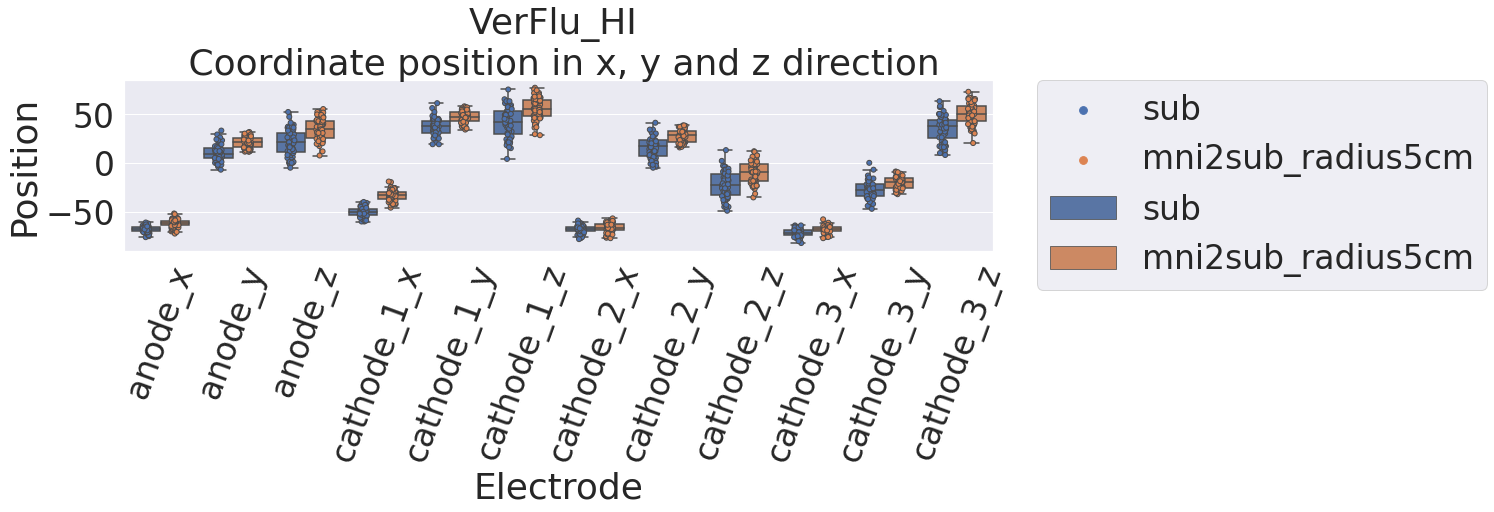

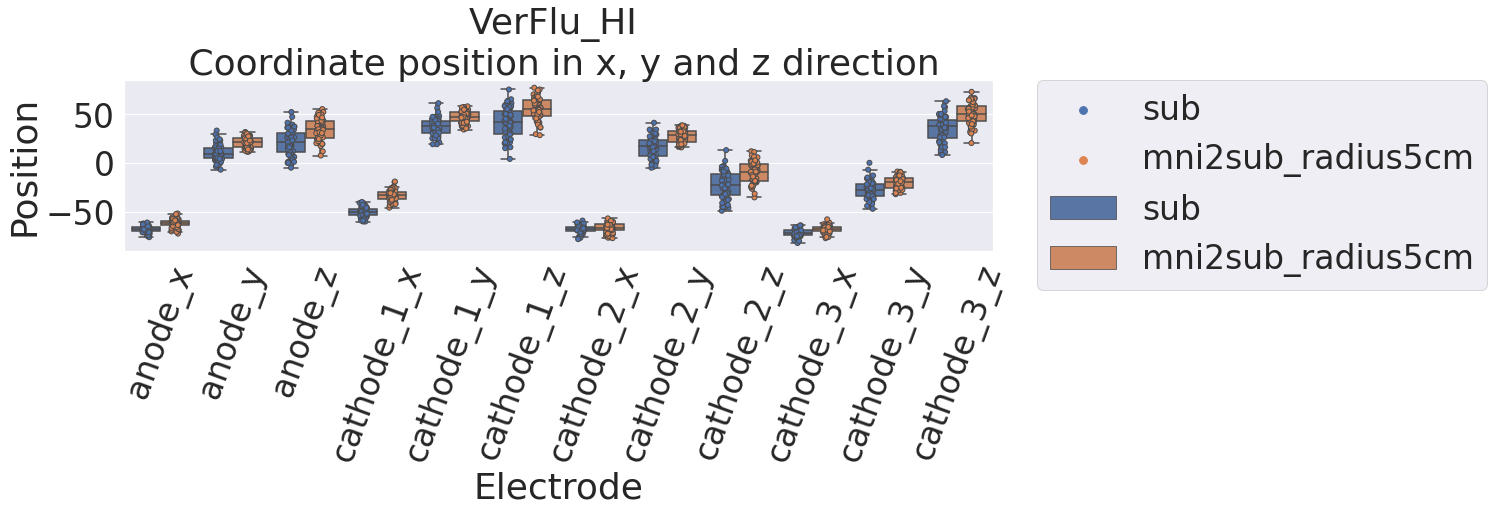

In [60]:
Exp='VerFlu_HI'
df_all_HI =get_plot_bar_Exp(dic_all[f'df_{Exp}_Kopf_sub'],dic_all[f'df_{Exp}_Kopf_mni_radius5cm'],dic_all[f'df_{Exp}_Zahl_sub'],dic_all[f'df_{Exp}_Zahl_mni_radius5cm'])
df_all =get_plot_bar_Exp(dic_all[f'df_{Exp}_Kopf_sub'],dic_all[f'df_{Exp}_Kopf_mni_radius5cm'],dic_all[f'df_{Exp}_Zahl_sub'],dic_all[f'df_{Exp}_Zahl_mni_radius5cm'])

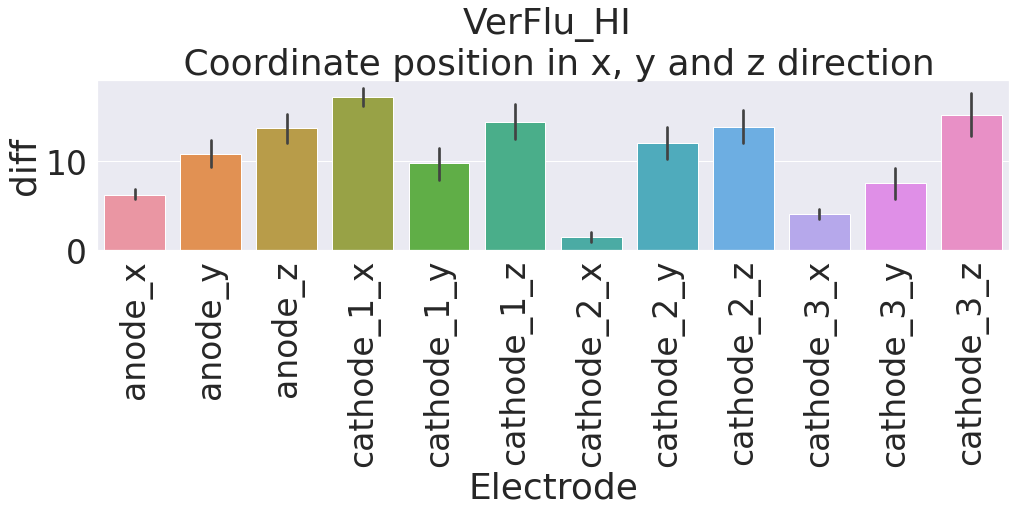

In [61]:
df_all['index']=df_all['index'].str.replace('_sub','')
df_all['index']=df_all['index'].str.replace('_mni2sub_radius5cm','')
df_all['index']=df_all['index'].str.replace('_Zahl','')
df_all['index']=df_all['index'].str.replace('_Kopf','')
df_diff_HI=plot_diff(df_all)

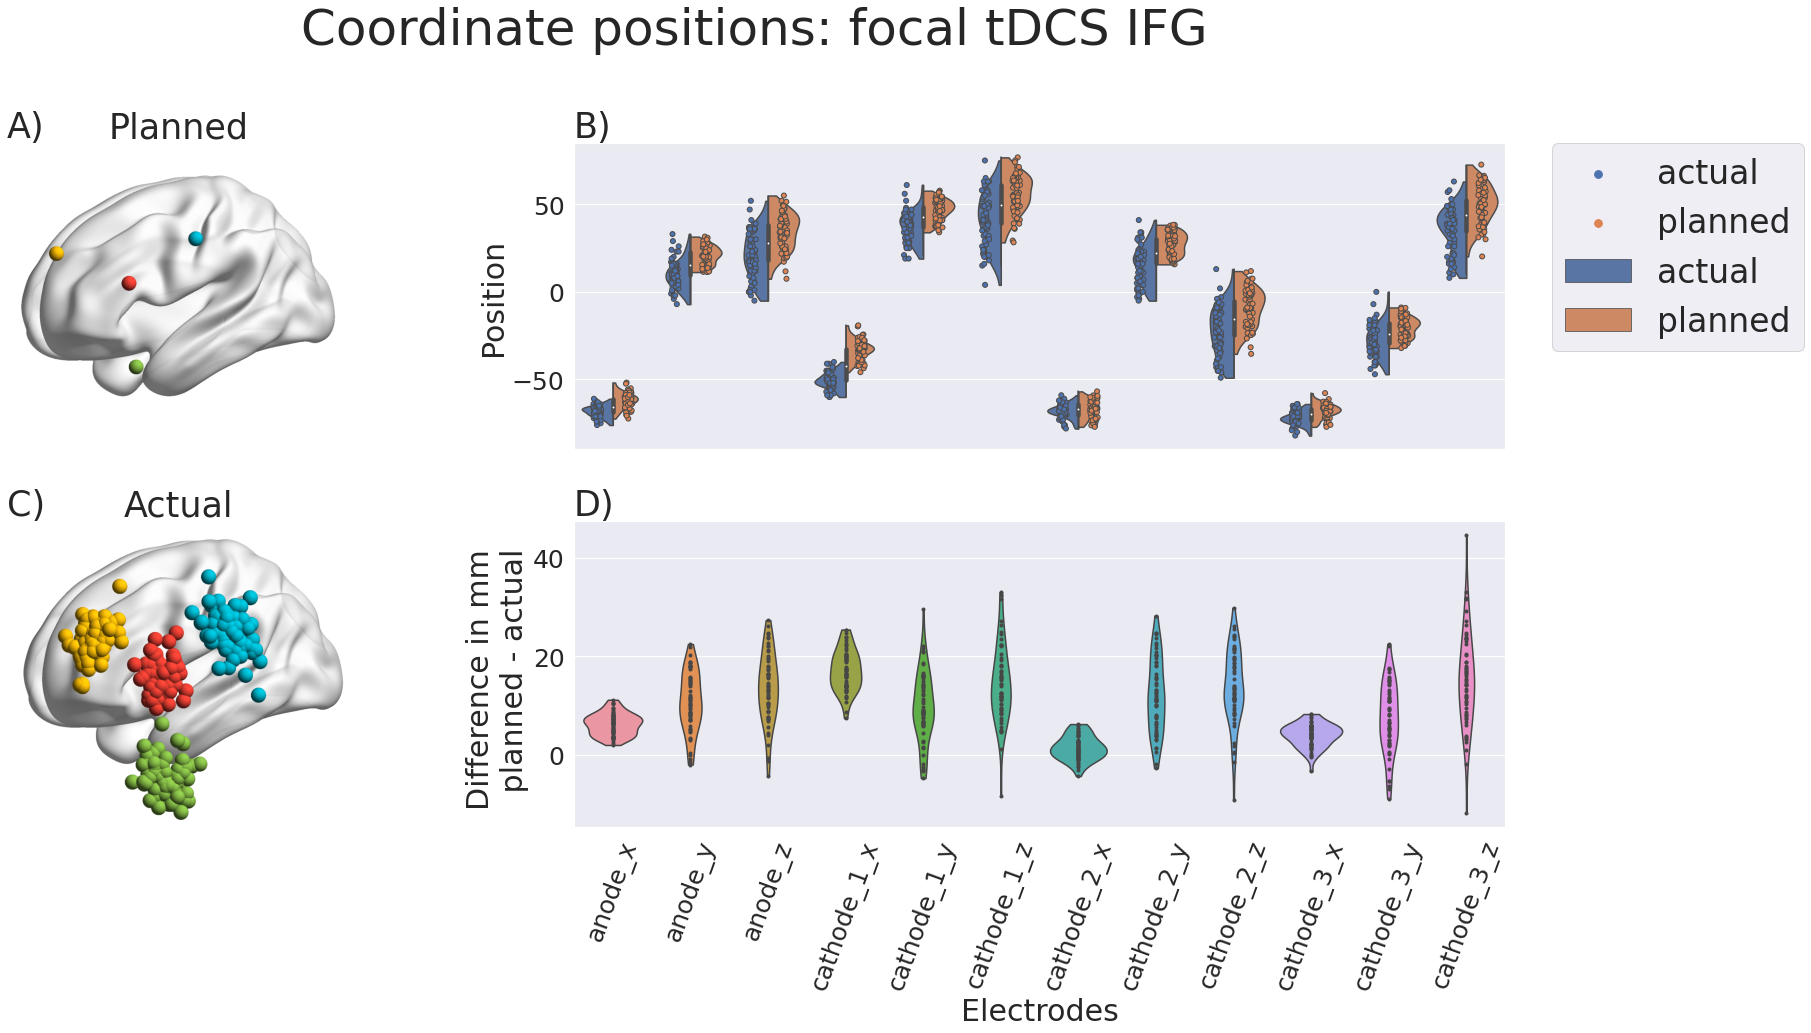

In [62]:

plot_coord_AND_diff(df_all, df_diff_HI,dic)


In [63]:
# scatter plot to check for outlier
df_diff_HI.hvplot.scatter(x='Electrode',y='diff',by='index', width=800)

:NdOverlay   [index]
   :Scatter   [Electrode]   (diff)

## VerFlu_HM (focal tDCS M1)

VerFlu_HM concat
VerFlu_HM concat


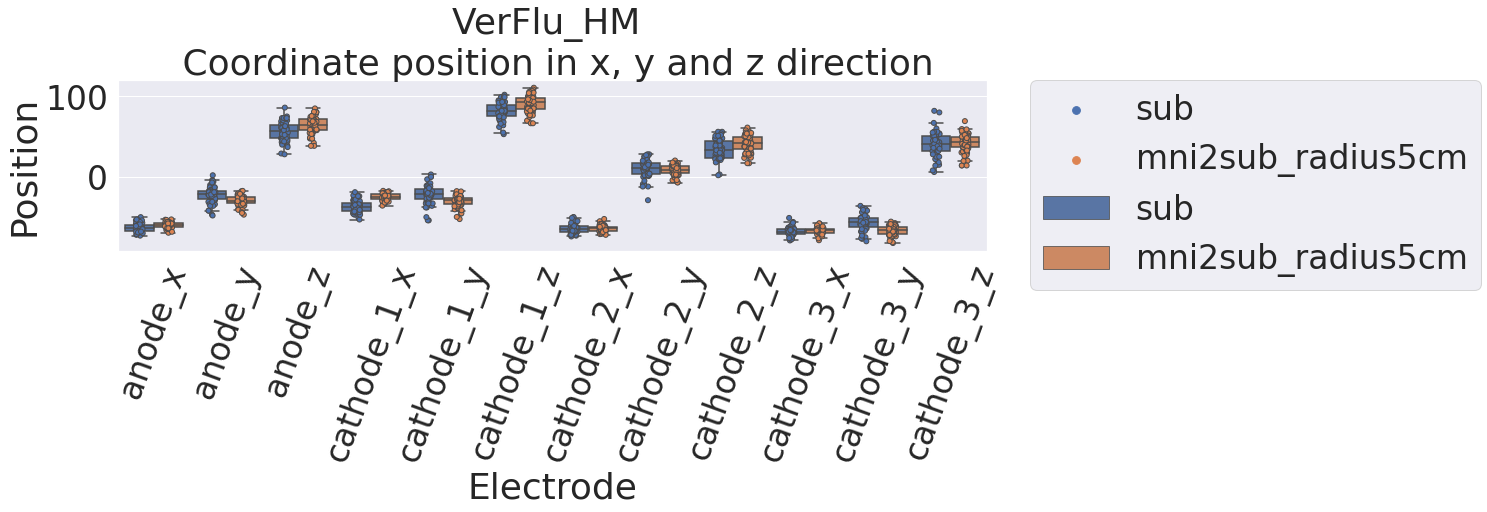

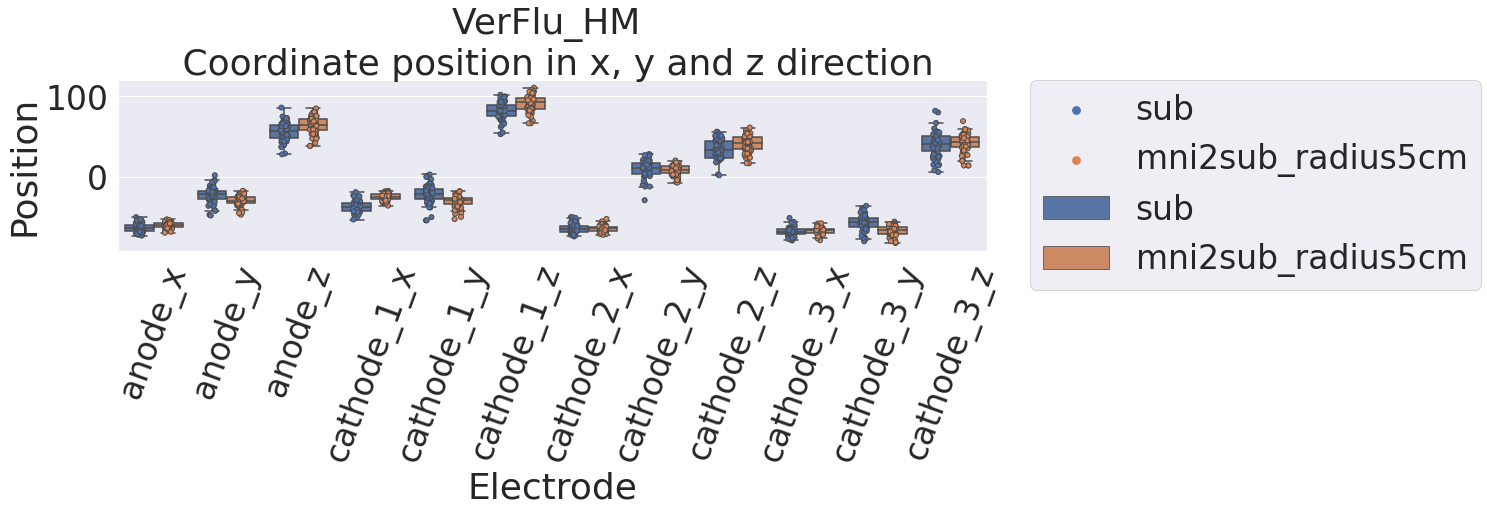

In [64]:
#anodey<-x over -50 , anody_y near zero outlier due to sub-14 Kopf electrode position to high
#anode_y near -50 sub-2 Kopf and sub-3 Zahl
#cathode_1_y under -50 cathode_1_z  near 50 sub01 zahl electrode position to low
#cathode_1_y under -50 cathode_2_y under -70 sub-02 Kopf
#sub 09 cathode_2_x near -50
#cathode_3_x -50 sub15 Kopf and Zahl cathode_3_y sub15 Kopf    - sub Kopf orientation 45 grad nach links geschiftet, falsch angelegt


Exp='VerFlu_HM'
df_all_HM=get_plot_bar_Exp(dic_all[f'df_{Exp}_Kopf_sub'],dic_all[f'df_{Exp}_Kopf_mni_radius5cm'],dic_all[f'df_{Exp}_Zahl_sub'],dic_all[f'df_{Exp}_Zahl_mni_radius5cm'])
df_all=get_plot_bar_Exp(dic_all[f'df_{Exp}_Kopf_sub'],dic_all[f'df_{Exp}_Kopf_mni_radius5cm'],dic_all[f'df_{Exp}_Zahl_sub'],dic_all[f'df_{Exp}_Zahl_mni_radius5cm'])

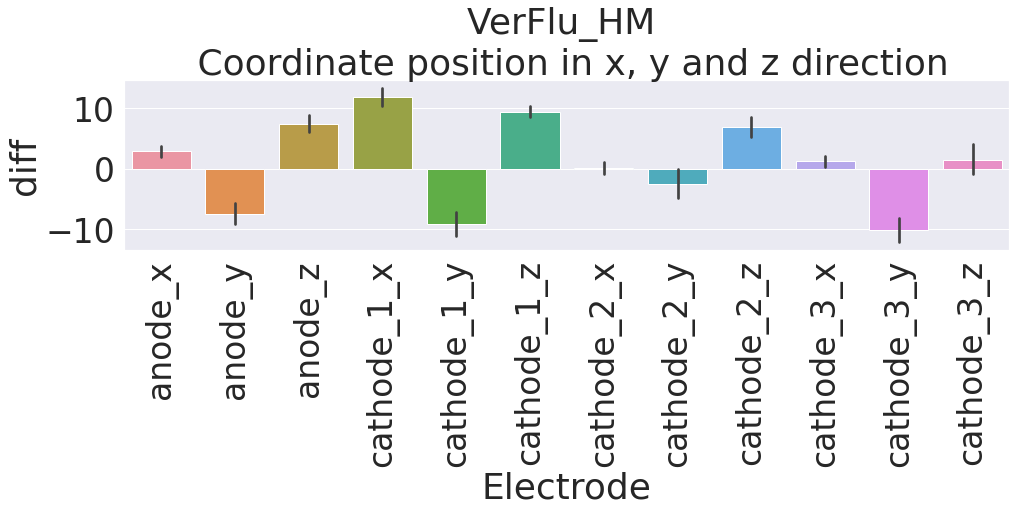

In [65]:
df_all['index']=df_all['index'].str.replace('_sub','')
df_all['index']=df_all['index'].str.replace('_radius5cm','')
df_all['index']=df_all['index'].str.replace('_mni2sub','')
df_all['index']=df_all['index'].str.replace('_Zahl','')
df_all['index']=df_all['index'].str.replace('_Kopf','')
df_diff_HM=plot_diff(df_all)

In [66]:
#df_all.groupby(['sim_space','Electrode']).mean()
df_all['index']=df_all['index'].str.replace('_sub','')
df_all['index']=df_all['index'].str.replace('_radius5cm','')
df_all['index']=df_all['index'].str.replace('_mni2sub','')
df_all['index']=df_all['index'].str.replace('_Zahl','')
df_all['index']=df_all['index'].str.replace('_Kopf','')

df_diff_HM.hvplot.scatter(x='Electrode',y='diff',by='index', width=800)


:NdOverlay   [index]
   :Scatter   [Electrode]   (diff)

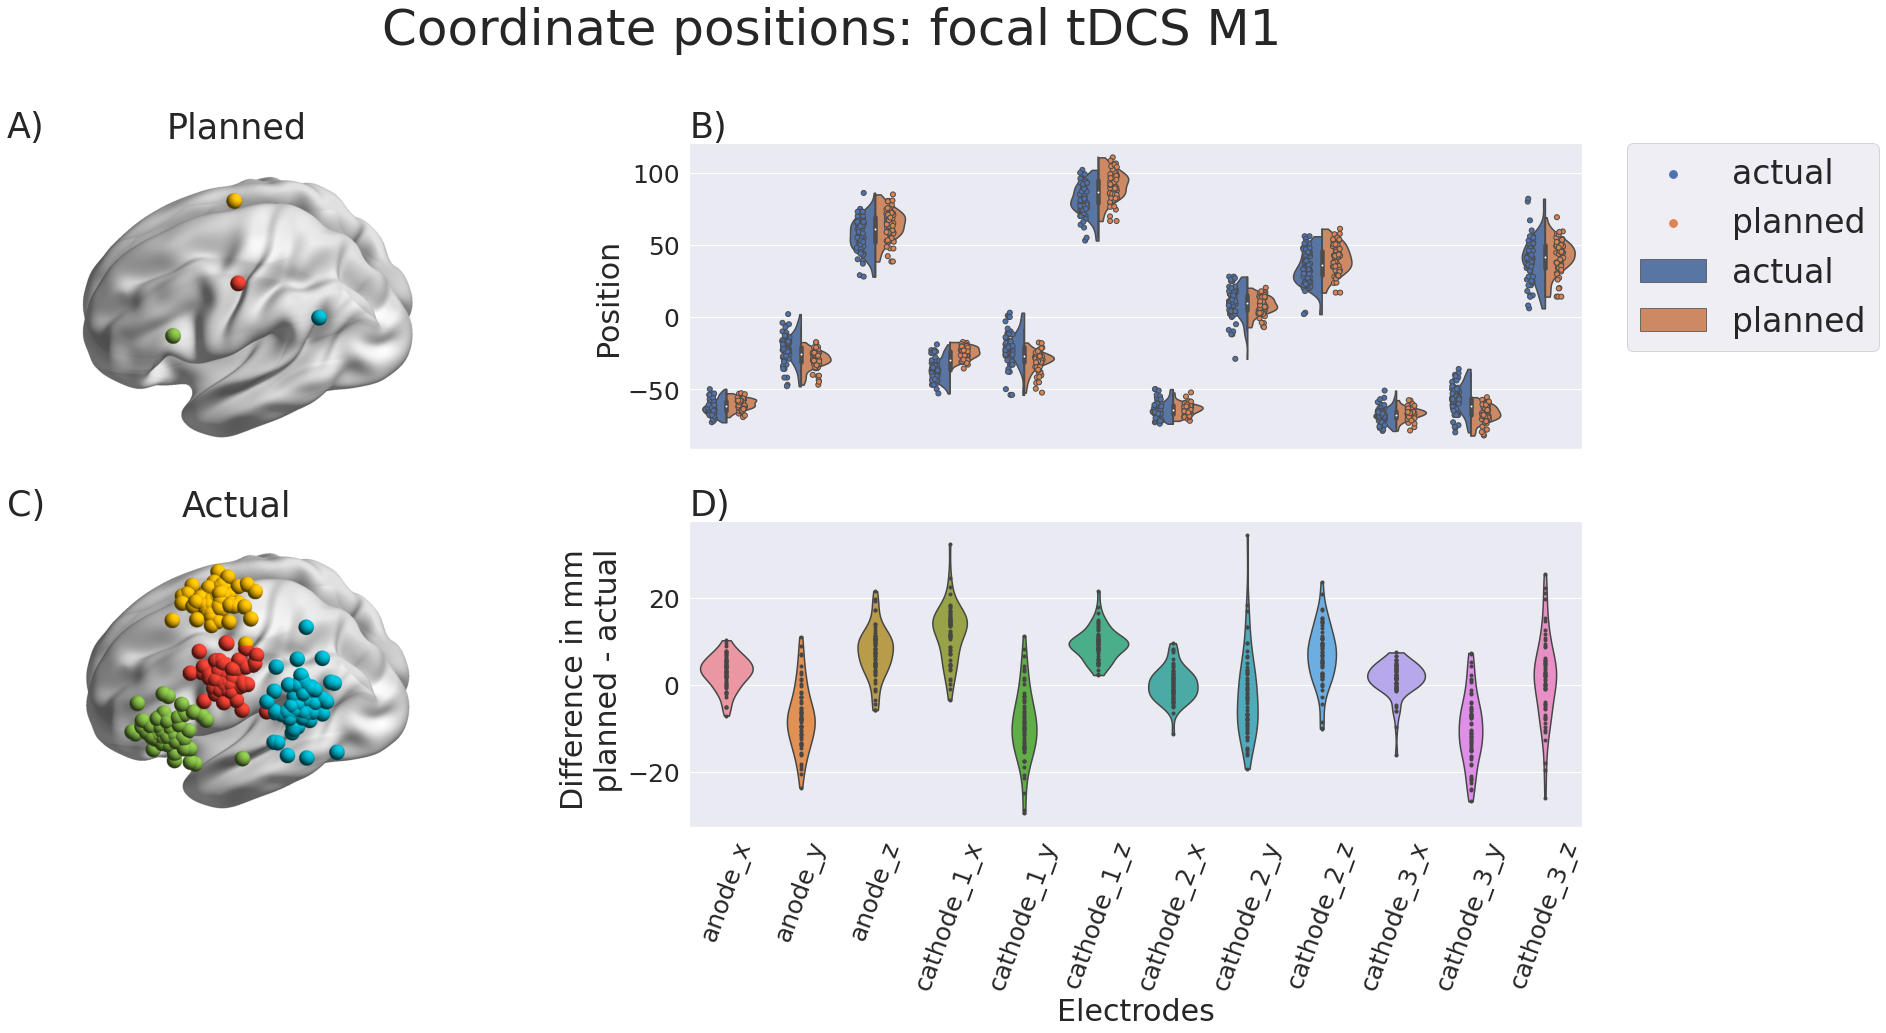

In [67]:
plot_coord_AND_diff(df_all, df_diff_HM,dic)

# konvent tDCS
## VerFlu TI (conventional tDCS IFG)

In [68]:
dic={}
#for Exp in ['VerFlu_HI', 'VerFlu_HM','VerFlu_TM','VerFlu_TI']:
for Exp in ['VerFlu_TM','VerFlu_TI']:
    for Session in ['Kopf','Zahl']:
        [dic_all,Exp,Session]=get_data_loop(Exp,Session, dic)
    

VerFlu_TM Kopf ['sub-27', 'sub-34', 'sub-46', 'sub-19'] 34
VerFlu_TM Kopf ['sub-27', 'sub-34', 'sub-46', 'sub-19'] 34
VerFlu_TM Zahl ['sub-27', 'sub-34', 'sub-46', 'sub-19'] 34
VerFlu_TM Zahl ['sub-27', 'sub-34', 'sub-46', 'sub-19'] 34
VerFlu_TI Kopf ['sub-14', 'sub-33', 'sub-34', 'sub-44'] 36
VerFlu_TI Kopf ['sub-14', 'sub-33', 'sub-34', 'sub-44'] 33
VerFlu_TI Zahl ['sub-14', 'sub-33', 'sub-34', 'sub-44'] 36
VerFlu_TI Zahl ['sub-14', 'sub-33', 'sub-34', 'sub-44'] 33


VerFlu_TI concat
VerFlu_TI concat


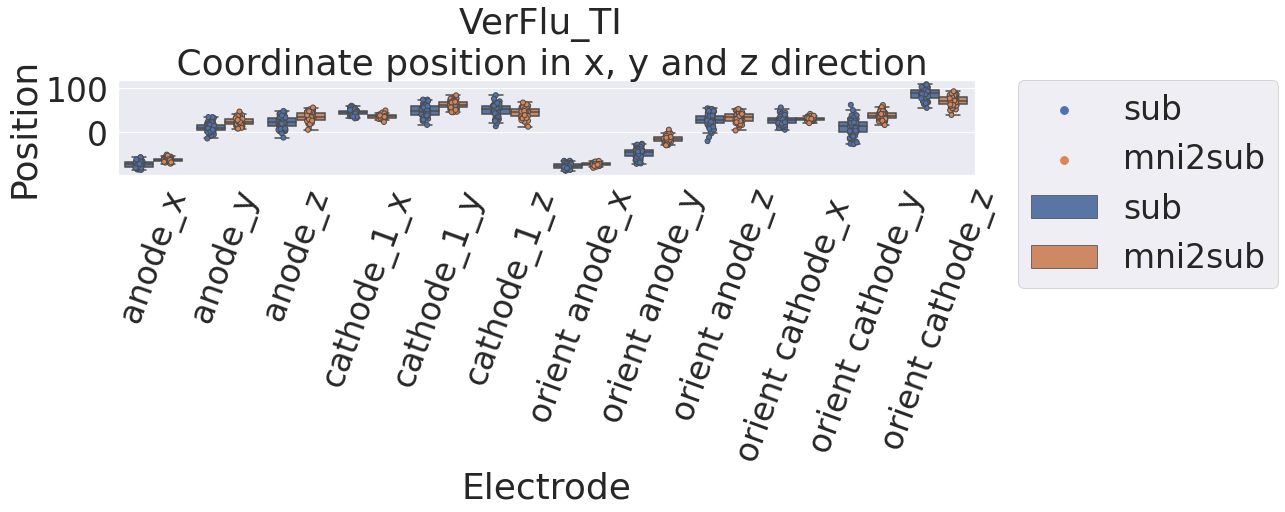

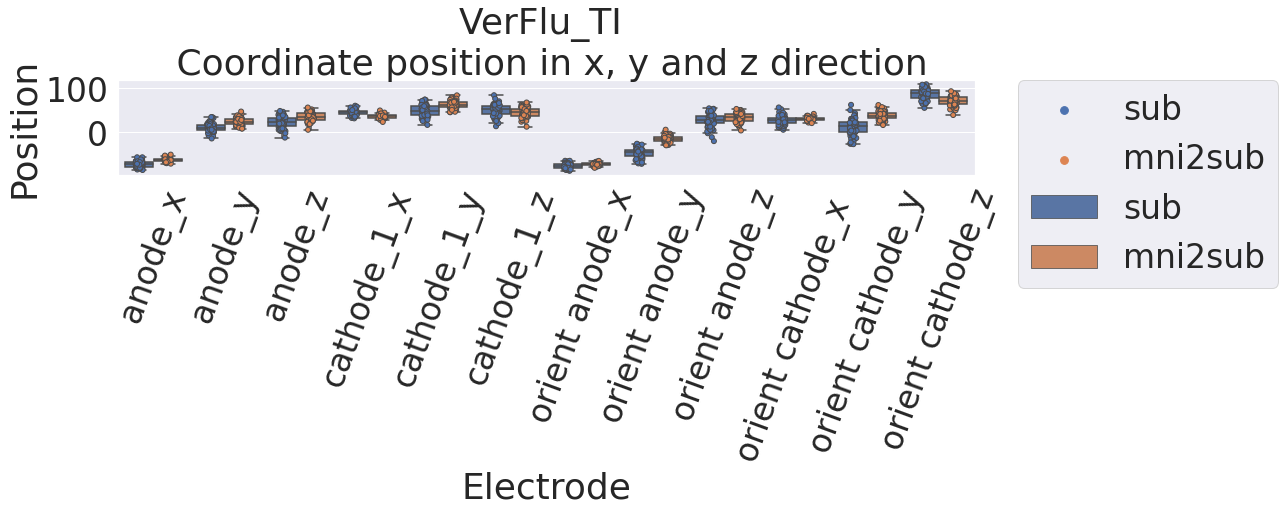

In [69]:
#Exp=easygui.buttonbox('Choose your Experiment', 'Experiment', ('VerFlu_HI', 'VerFlu_TI', 'VerFlu_HM','VerFlu_TM','VerFlu_Phon'))
Exp='VerFlu_TI'
df_all_TI=get_plot_bar_Exp(dic_all[f'df_{Exp}_Kopf_sub'],dic_all[f'df_{Exp}_Kopf_mni'],dic_all[f'df_{Exp}_Zahl_sub'],dic_all[f'df_{Exp}_Zahl_mni'])
df_all=get_plot_bar_Exp(dic_all[f'df_{Exp}_Kopf_sub'],dic_all[f'df_{Exp}_Kopf_mni'],dic_all[f'df_{Exp}_Zahl_sub'],dic_all[f'df_{Exp}_Zahl_mni'])

64

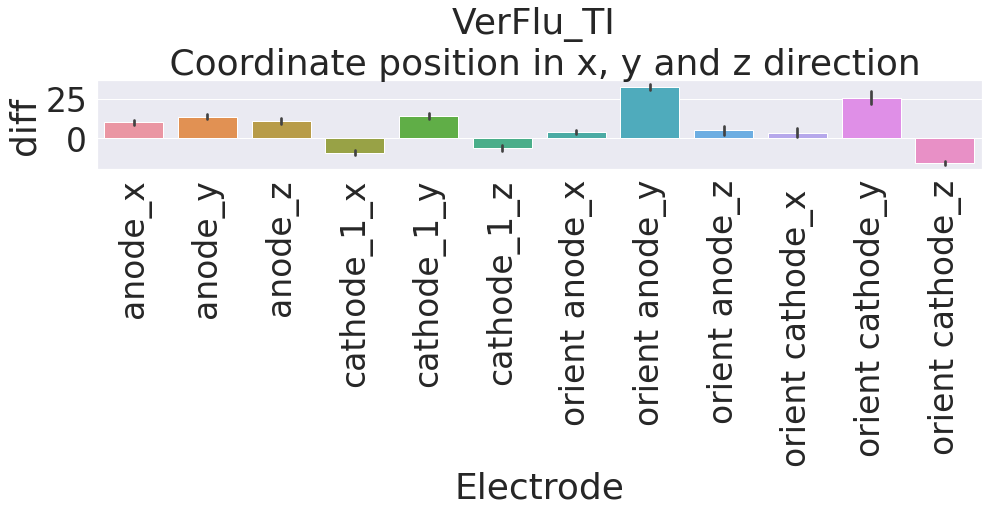

In [70]:
df_all['index']=df_all['index'].str.replace('_sub','')
df_all['index']=df_all['index'].str.replace('_mni2sub','')
df_all['index']=df_all['index'].str.replace('_Zahl','')
df_all['index']=df_all['index'].str.replace('_Kopf','')
df_diff_TI=plot_diff(df_all)
len(df_diff_TI['index'].unique())

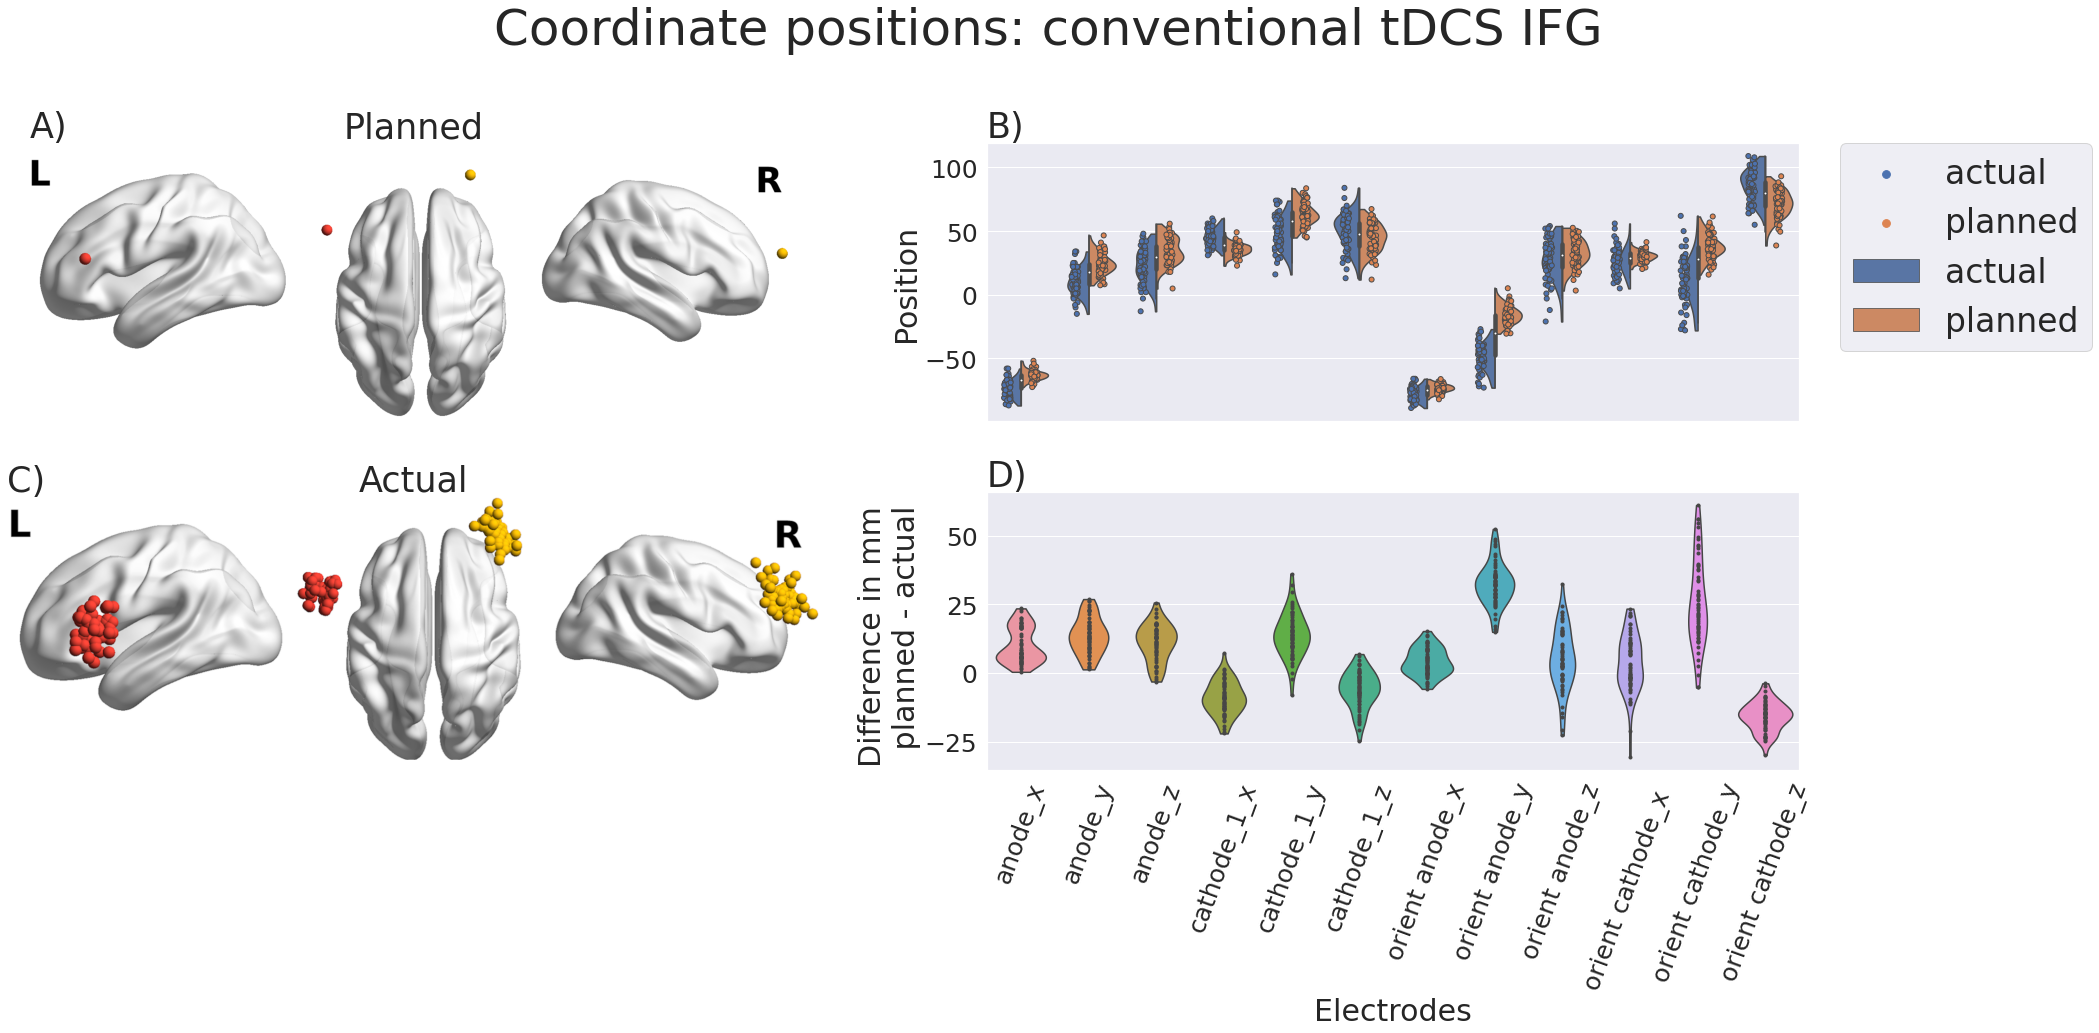

In [71]:
plot_coord_AND_diff(df_all, df_diff_TI, dic)

In [72]:
df_all['index']=df_all['index'].str.replace('_sub','')
df_all['index']=df_all['index'].str.replace('_mni2sub','')
df_all['index']=df_all['index'].str.replace('_Zahl','')
df_all['index']=df_all['index'].str.replace('_Kopf','')
plot1=df_diff_TI.hvplot.scatter(x='Electrode',y='diff',by='index', width=800)
plot1
#df_diff_TI

:NdOverlay   [index]
   :Scatter   [Electrode]   (diff)

## VerFlu TM (conventional tDCS M1)

VerFlu_TM concat
VerFlu_TM concat


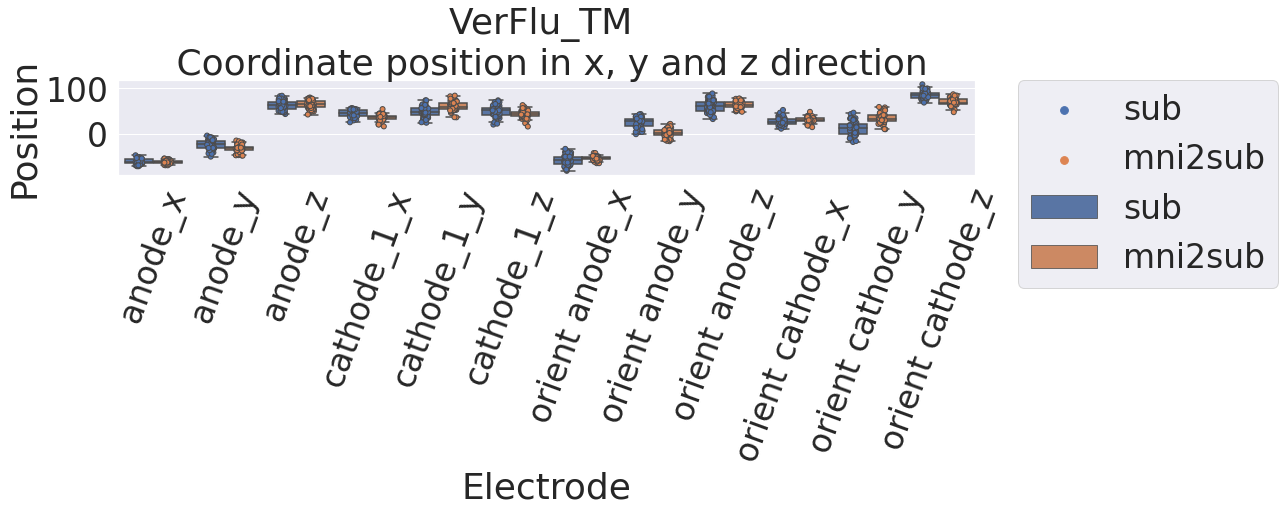

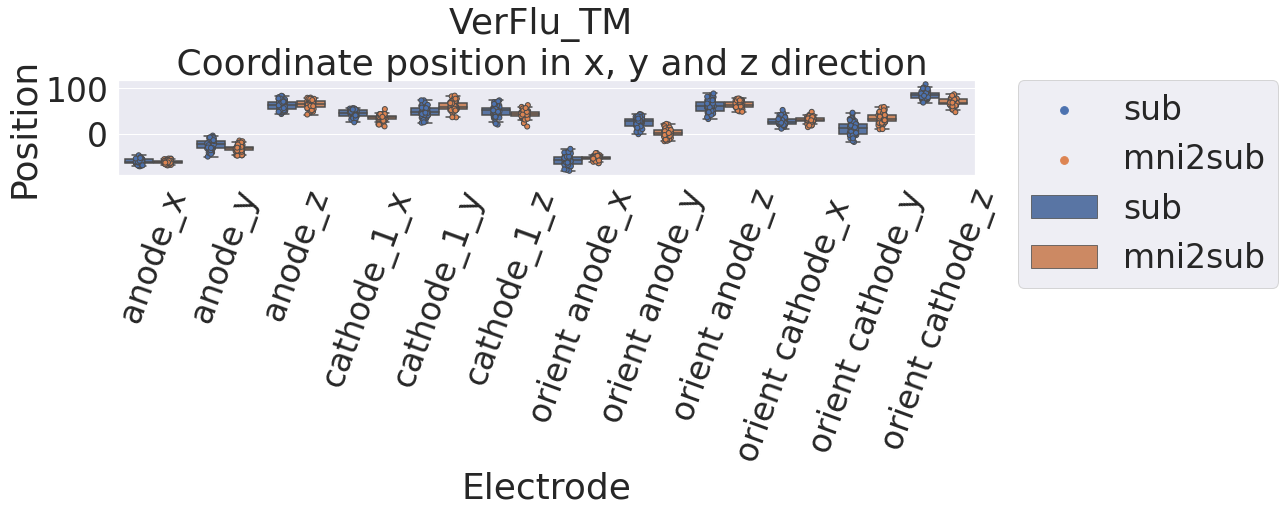

In [73]:
Exp='VerFlu_TM'
df_all_TM=get_plot_bar_Exp(dic_all[f'df_{Exp}_Kopf_sub'],dic_all[f'df_{Exp}_Kopf_mni'],dic_all[f'df_{Exp}_Zahl_sub'],dic_all[f'df_{Exp}_Zahl_mni'])
df_all=get_plot_bar_Exp(dic_all[f'df_{Exp}_Kopf_sub'],dic_all[f'df_{Exp}_Kopf_mni'],dic_all[f'df_{Exp}_Zahl_sub'],dic_all[f'df_{Exp}_Zahl_mni'])

60

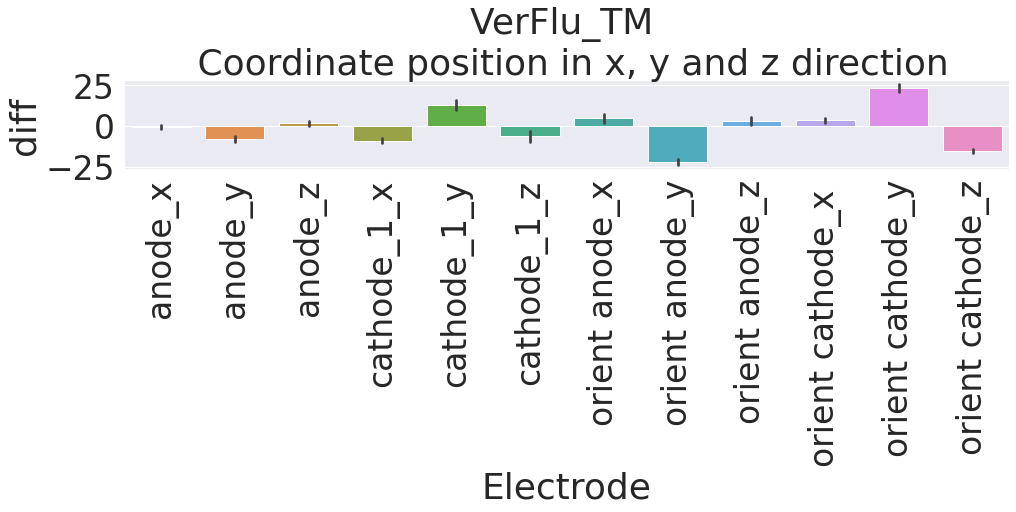

In [74]:
df_all['index']=df_all['index'].str.replace('_sub','')
df_all['index']=df_all['index'].str.replace('_mni2sub','')
df_all['index']=df_all['index'].str.replace('_Zahl','')
df_all['index']=df_all['index'].str.replace('_Kopf','')
df_diff_TM=plot_diff(df_all)
len(df_diff_TM['index'].unique())

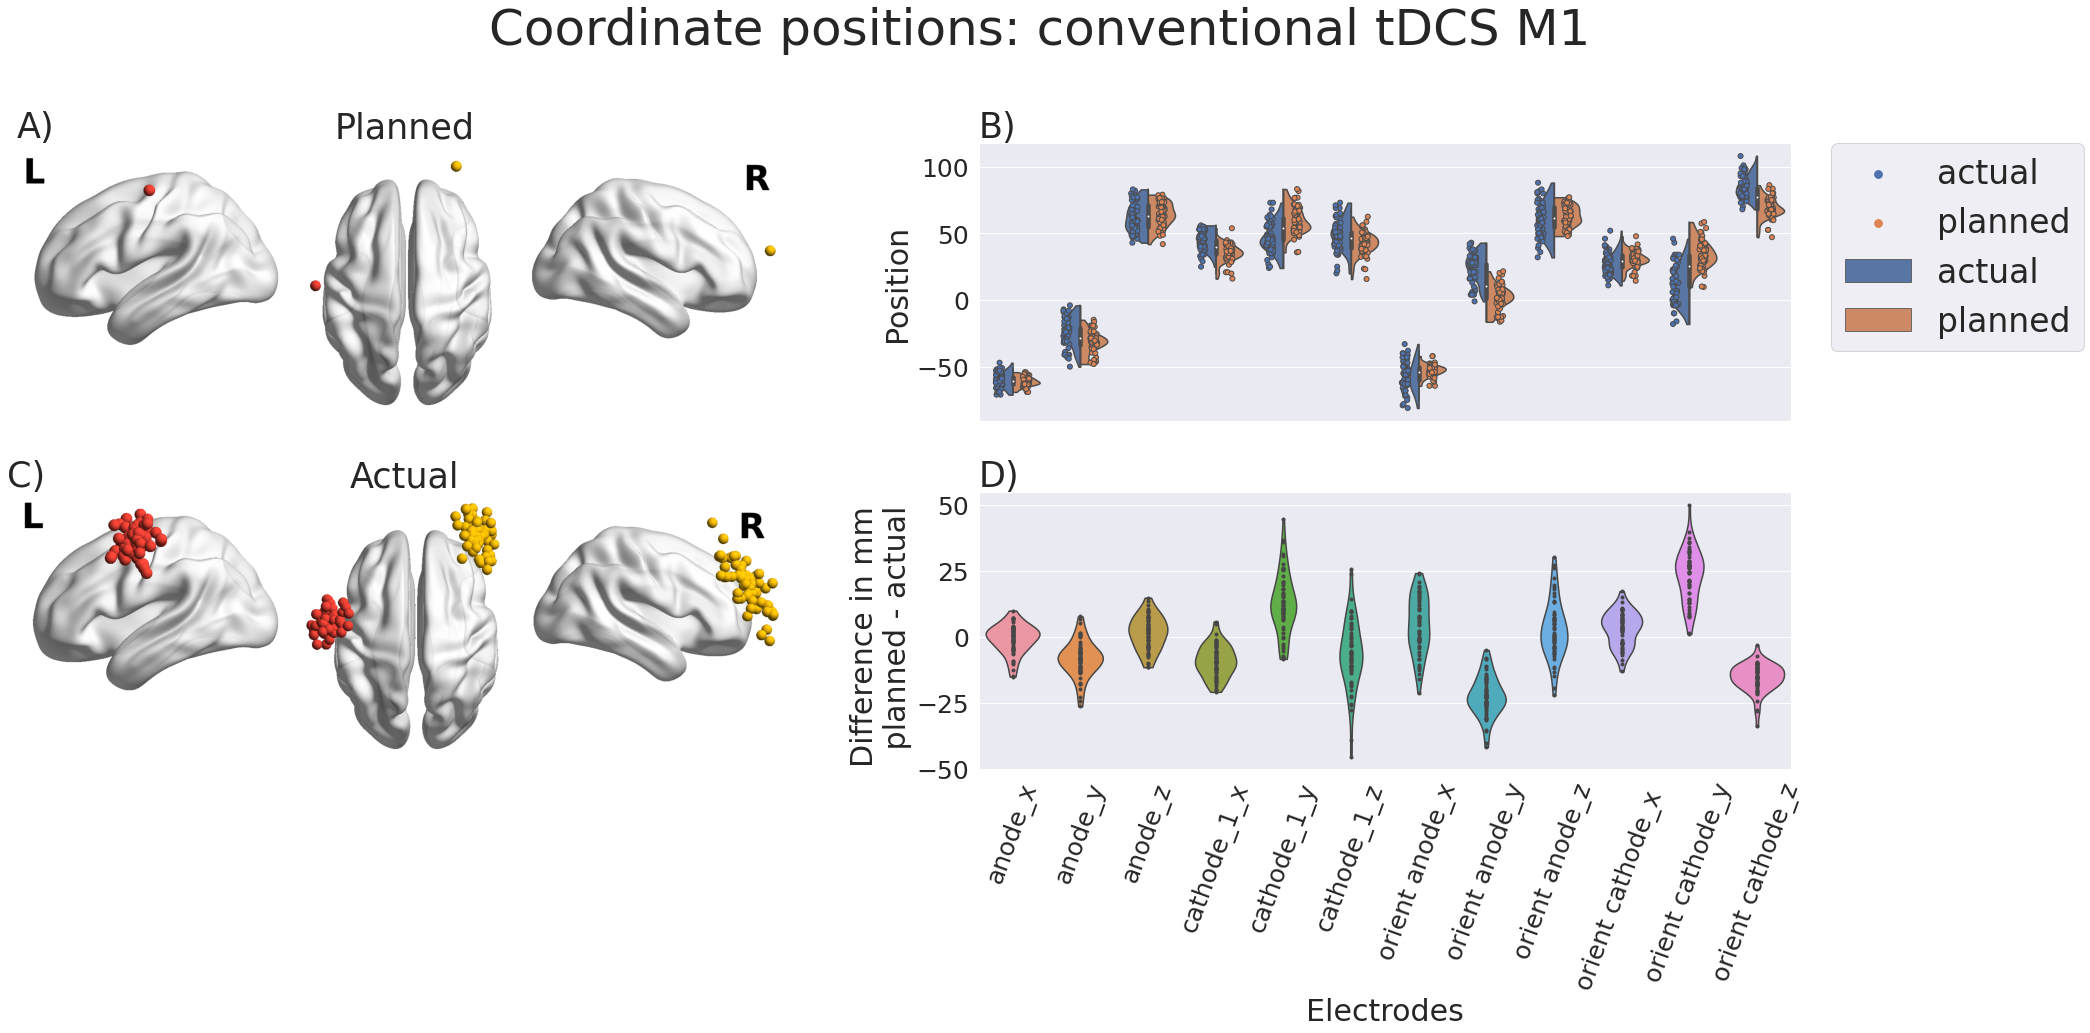

In [75]:
plot_coord_AND_diff(df_all, df_diff_TM, dic)

In [43]:
plot1=df_diff_TM.hvplot.scatter(x='Electrode',y='diff',by='index', width=800)

plot1

:NdOverlay   [index]
   :Scatter   [Electrode]   (diff)